# IMPORTING LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# dataset_url = "https://www.kaggle.com/datasets/forderation/breakhis-400x"
# od.download(dataset_url)

In [3]:
import json
import math
import os

from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Add, MaxPooling2D, Conv2D, Flatten, BatchNormalization

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile,VGG16
# from tensorflow.keras.applications import DenseNet201,VGG16
from tensorflow.keras.optimizers import Adam

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import gc
import itertools
from tqdm import tqdm
from PIL import Image
from functools import partial
from collections import Counter

%matplotlib inline

# LOADING AND PREPROCESSING

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/test/malignant',224))

100%|██████████| 369/369 [00:13<00:00, 28.12it/s]


# CREATE LABEL

In [5]:
# print label name
label =  {0: "benign", 1: "malignant"}
for i in label.keys() :
    print(i, label[i])

0 benign
1 malignant


In [6]:
# breast Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# VISUALIZE DATA

In [7]:
# #visualize data
# fig, axis = plt.subplots()
# axis.bar("test_data", 547, color='b', label='Test Data')
# axis.bar("train_data", 1148 , color='r', label='Train Data')
# legend = axis.legend()

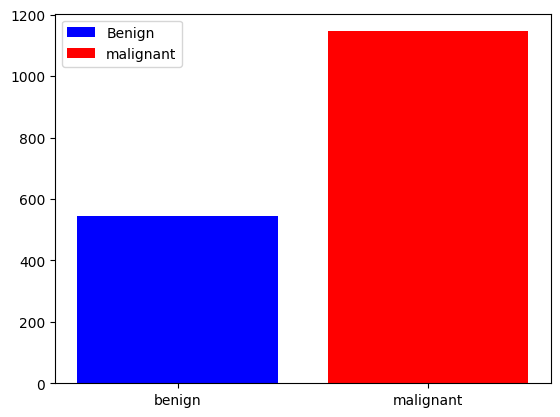

In [8]:
#visualize data
fig, axis = plt.subplots()
axis.bar("benign", 545, color = 'b', label = 'Benign')
axis.bar("malignant",1146 , color = 'r', label = 'malignant')
legend = axis.legend()

# TRAIN AND EVALUATION SPLIT

In [9]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size = 0.2,
    random_state = 11
)

# DISPLAY IMAGES

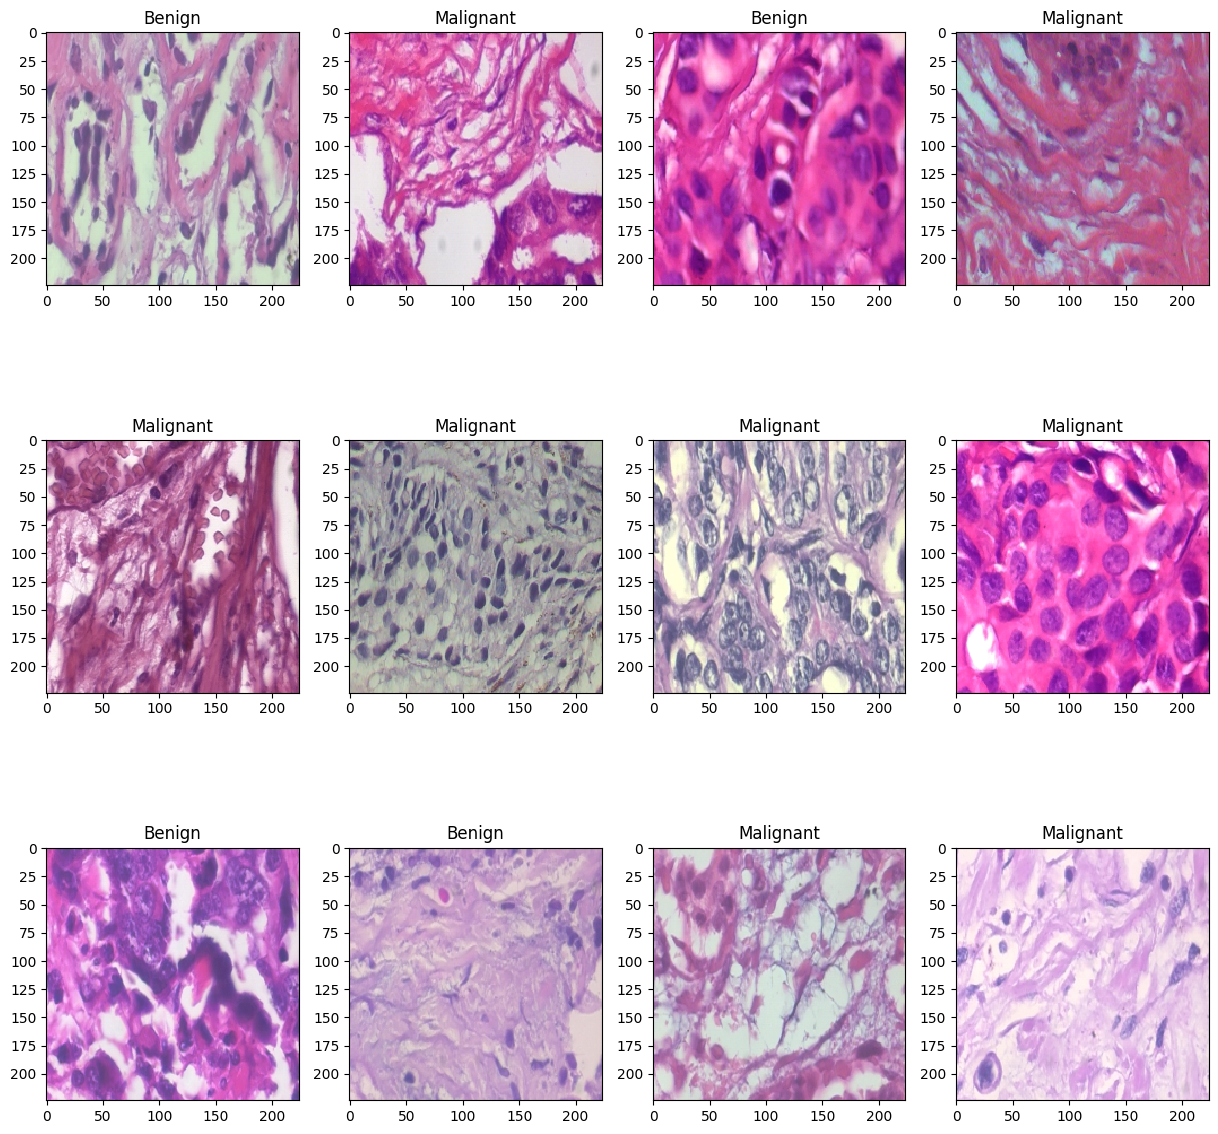

In [10]:
# # Display first 15 images of moles, and how they are classified
w = 60
h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# DATA GENERATOR

In [11]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range = 2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True,  # randomly flip images
    )

# BUILDING THE MODEL 1 (DenseNet)



In [12]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(lr=lr),
        metrics = ['accuracy']
    )

    return model

In [13]:
K.clear_session()
gc.collect()

#DenseNet-201 is a convolutional neural network that is 201 layers deep.
resnet = DenseNet201(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

74836368/74836368 [==============================] - 1s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18333506 (69.94 MB)
Trainable params: 1810

In [14]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor = 'accuracy', patience = 5,
                                  verbose = 1,factor = 0.2, min_lr = 1e-7)

# Checkpoint
filepath ="Densenet.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

#early stop  to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

# TRAINING AND EVALUATION

In [15]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs = 30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/30
58/57 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.7778
Epoch 1: accuracy improved from -inf to 0.77778, saving model to Densenet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 172s 799ms/step - loss: 0.5549 - accuracy: 0.7778 - val_loss: 59.2812 - val_accuracy: 0.3391 - lr: 0.0010
Epoch 2/30
58/57 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.8083
Epoch 2: accuracy improved from 0.77778 to 0.80828, saving model to Densenet.h5
57/57 [==============================] - 21s 367ms/step - loss: 0.4752 - accuracy: 0.8083 - val_loss: 6.7104 - val_accuracy: 0.4783 - lr: 0.0010
Epoch 3/30
58/57 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.8355
Epoch 3: accuracy improved from 0.80828 to 0.83551, saving model to Densenet.h5
57/57 [==============================] - 22s 383ms/step - loss: 0.4329 - accuracy: 0.8355 - val_loss: 1.5395 - val_accuracy: 0.6739 - lr: 0.0010
Epoch 4/30
58/57 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.8322
Epoch 4: accuracy did not improve from 0.83551
57/57 [==============================] - 19s 334ms/step - loss: 0.4110 - a

In [16]:
#evaluate model
model.evaluate(x_val, y_val)

8/8 [==============================] - 1s 124ms/step - loss: 0.1741 - accuracy: 0.9174


[0.17405924201011658, 0.917391300201416]

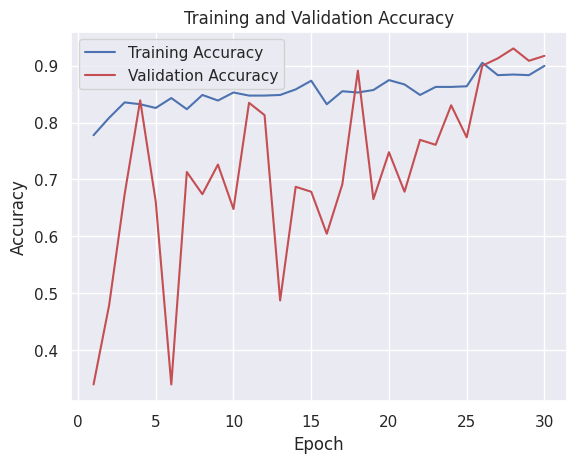

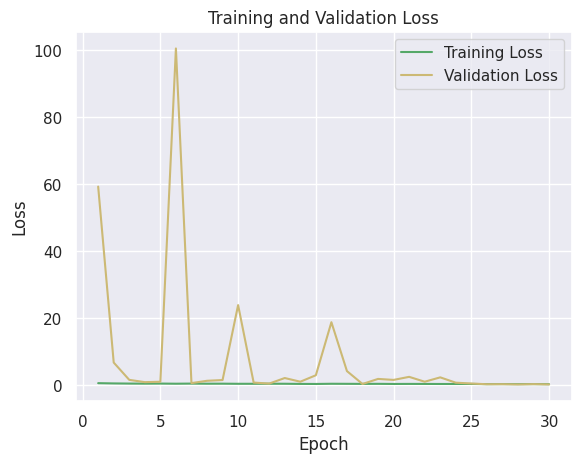

In [17]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, accuracy, color='b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

#loss plot
plt.figure()
plt.plot(epochs, loss, color='g', label='Training Loss')
plt.plot(epochs, val_loss, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# PREDICTION

In [18]:
Y_val_pred = model.predict(x_val)

8/8 [==============================] - 5s 144ms/step


In [19]:
Y_pred = model.predict(X_test)
# Y_pred = model.predict(X_train)

18/18 [==============================] - 5s 300ms/step


In [20]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9173913043478261

In [21]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

34/34 [==============================] - 11s 203ms/step


 10%|█         | 1/10 [00:11<01:45, 11.75s/it]

34/34 [==============================] - 8s 247ms/step


 20%|██        | 2/10 [00:21<01:23, 10.40s/it]

34/34 [==============================] - 8s 226ms/step


 30%|███       | 3/10 [00:30<01:07,  9.71s/it]

34/34 [==============================] - 7s 207ms/step


 40%|████      | 4/10 [00:38<00:55,  9.18s/it]

34/34 [==============================] - 9s 252ms/step


 50%|█████     | 5/10 [00:48<00:46,  9.33s/it]

34/34 [==============================] - 8s 239ms/step


 60%|██████    | 6/10 [00:57<00:37,  9.31s/it]

34/34 [==============================] - 7s 204ms/step


 70%|███████   | 7/10 [01:05<00:26,  8.93s/it]

34/34 [==============================] - 8s 249ms/step


 80%|████████  | 8/10 [01:14<00:18,  9.11s/it]

34/34 [==============================] - 8s 227ms/step


 90%|█████████ | 9/10 [01:23<00:09,  9.05s/it]

34/34 [==============================] - 7s 204ms/step


100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


In [22]:
#evaluate model
model.evaluate(x_val, y_val)

8/8 [==============================] - 1s 119ms/step - loss: 0.1741 - accuracy: 0.9174


[0.17405924201011658, 0.917391300201416]

# CONFUSION MATRIX

In [23]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[153  23]
 [ 23 346]]


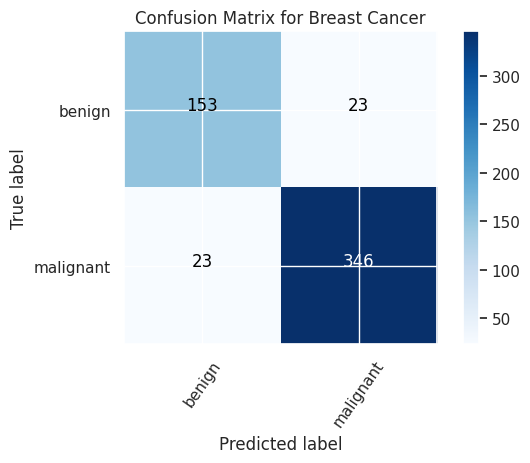

In [24]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Confusion Matrix for Breast Cancer')

Confusion matrix, without normalization
[[145  31]
 [ 18 351]]


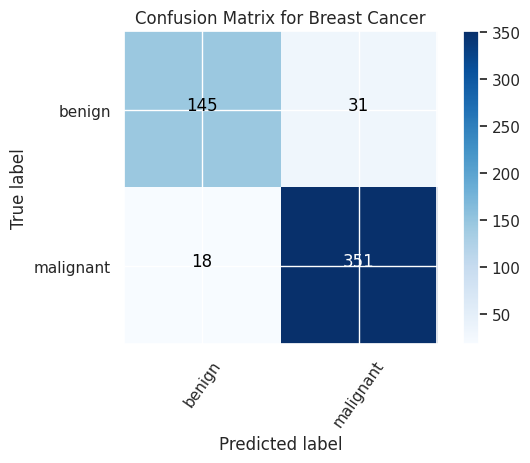

In [25]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Confusion Matrix for Breast Cancer')

# CLASSIFICATION REPORT

In [26]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86       176
           1       0.92      0.95      0.93       369

    accuracy                           0.91       545
   macro avg       0.90      0.89      0.90       545
weighted avg       0.91      0.91      0.91       545



# ROC AND AUC

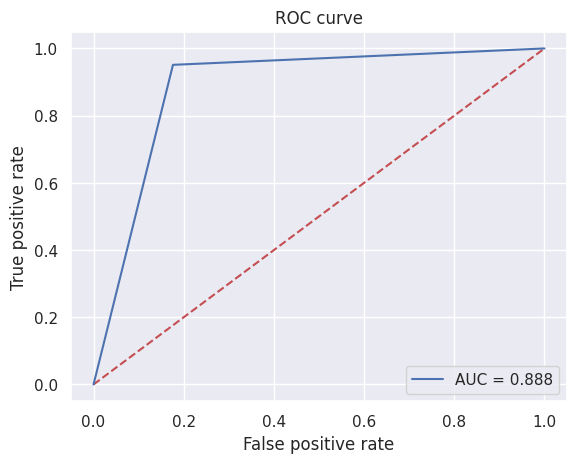

In [27]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

# DISPLAY SOME PREDICTIONS

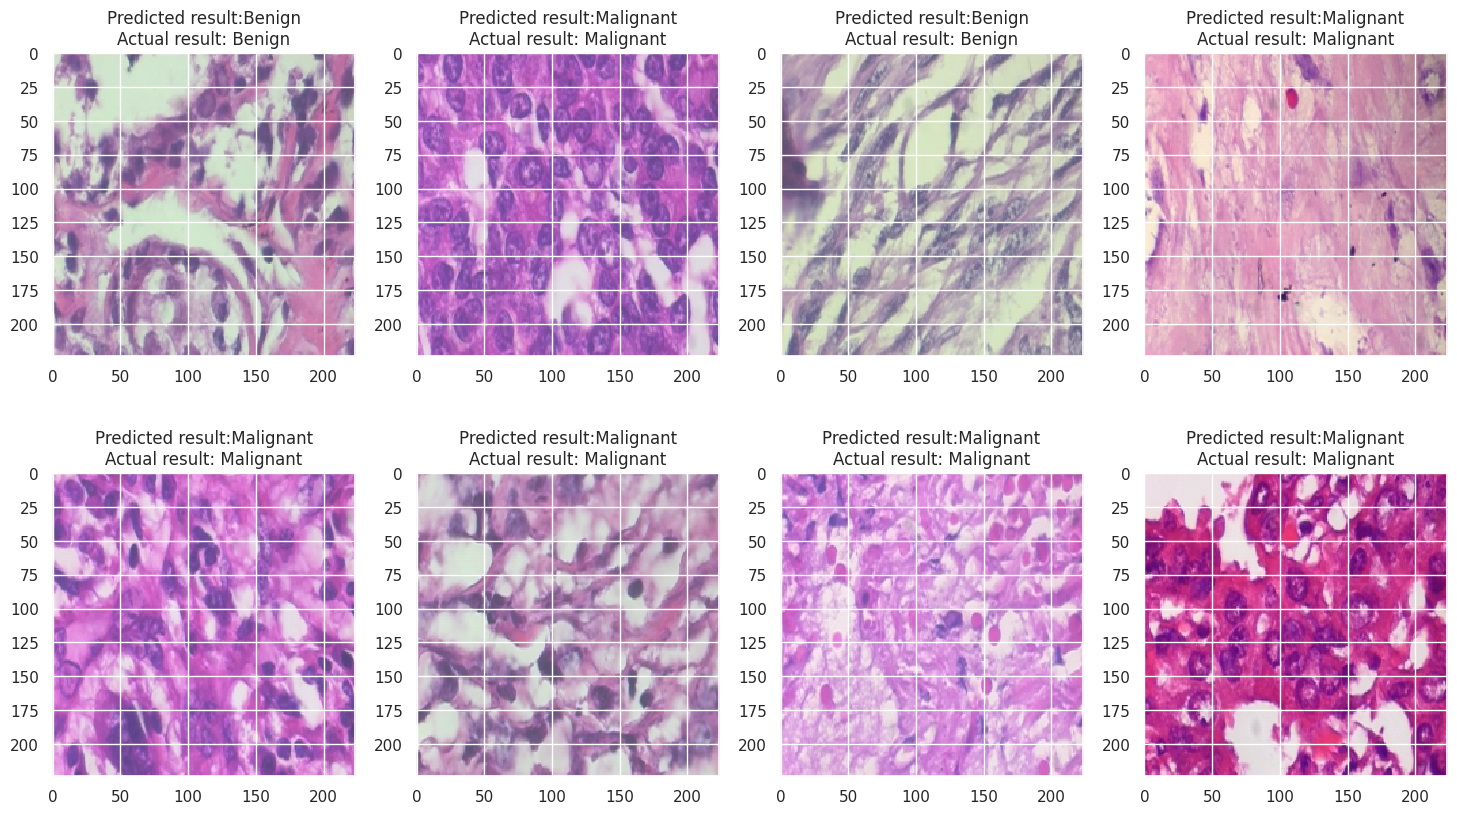

In [28]:
i = 0
prop_class = []
mis_class = []

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i = 0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break


# Display first 8 images of benign
w = 60
h = 40
fig = plt.figure(figsize = (18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"


for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

# TEST MODEL

1/1 [==============================] - 3s 3s/step
[0]
benign


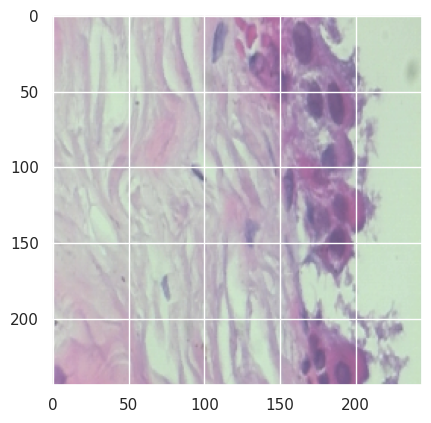

In [29]:
#model 1 test 1
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

1/1 [==============================] - 0s 35ms/step
[1]
malignant


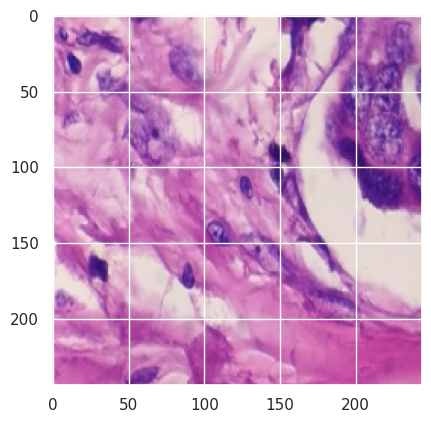

In [30]:
# model 1 test 2
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/test/malignant/SOB_M_DC-14-12312-400-026.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)


1/1 [==============================] - 3s 3s/step
Malignant


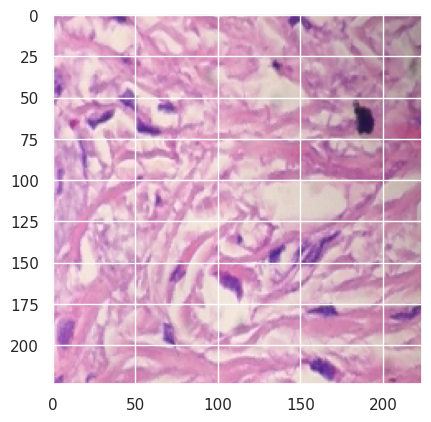

In [33]:
# Try on test data

import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

img = image.load_img("/content/drive/MyDrive/BreaKHis 400X/train/malignant/SOB_M_DC-14-13412-400-026.png",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model("/content/Densenet.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("Benign")
else:
    print("Malignant")

1/1 [==============================] - 3s 3s/step
Benign


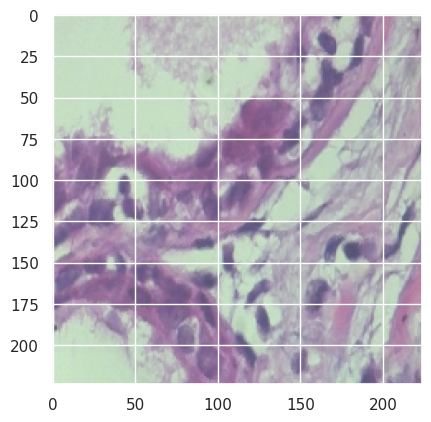

In [34]:
# Try on test data

import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

img = image.load_img("/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-014.png",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model("/content/Densenet.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("Benign")
else:
    print("Malignant")